In [6]:
import os
import cv2 as cv
import json
import shutil
import random
import numpy as np
import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from src.create_annotations import *
from shapely.geometry import Polygon, MultiPolygon
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import morphology
from skimage.filters import threshold_otsu
from skimage.transform import rotate
from skimage import exposure
from skimage.filters import unsharp_mask
from skimage.restoration import denoise_tv_chambolle
from skimage.transform import resize


In [16]:
# Create the output directory if it doesn't exist
output_dir = 'output/processed_images'
os.makedirs(output_dir, exist_ok=True)

In [17]:
image_list = []
image_list2 = []
for filename in glob.glob('dataset/input_images/*.jpg'):  # Assuming images are in JPG format
    im = Image.open(filename)
    image_list.append(im)
    image_list2.append(im.copy())


In [51]:
def image_color(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

Skew Correction. ...
Image Scaling. ...
Noise Removal. ...
Thinning and Skeletonization. ...
Gray Scale image. ...
Thresholding or Binarization.

In [53]:
import cv2

def deskew(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    contour = max(contours, key=cv2.contourArea)

    # Get the minimum bounding rectangle of the contour
    rect = cv2.minAreaRect(contour)
    angle = rect[2]

    # Rotate the image to correct skew
    if angle < -45:
        angle += 90
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    # Convert the rotated image back to RGB
    # rotated_rgb = cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB)
    
    return image_color(rotated)



In [17]:
def scale_image(image, size=(200, 200)):
    return cv2.resize(image, size)

In [18]:
def remove_noise(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

In [19]:
def thin_skeletonize(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)
    skeletonized_image = morphology.skeletonize(binary_image / 255)
    return cv2.cvtColor(skeletonized_image.astype(np.uint8) * 255, cv2.COLOR_GRAY2BGR)


In [20]:
def binarize_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold_value = threshold_otsu(gray_image)
    return gray_image > threshold_value


In [21]:
def sharpen_image(image):
    return unsharp_mask(image, radius=1.0, amount=1.0)

In [22]:
def enhance_contrast(image):
    p2, p98 = np.percentile(image, (2, 98))
    return exposure.rescale_intensity(image, in_range=(p2, p98))


In [23]:
def super_resolution(image):
    # Placeholder function for super-resolution, as it requires a trained model or library implementation
    return resize(image, (image.shape[0]*2, image.shape[1]*2))

In [24]:
def denoise_image(image):
    return denoise_tv_chambolle(image, weight=0.1)

In [25]:
def color_correction(image):
    # Placeholder function for color correction
    return image

In [ ]:
# def save_images(image_list, output_dir):

#     # Iterate over the image list
#     for idx, im in enumerate(image_list):
#         # Convert PIL image to OpenCV format
#         cv_image = np.array(im)

#         # Skew Correction
#         deskewed_image = deskew(cv_image)

#         # Image Scaling
#         scaled_image = scale_image(deskewed_image)

#         # Noise Removal
#         noise_removed_image = remove_noise(scaled_image)

#         # Thinning and Skeletonization
#         skeletonized_image = thin_skeletonize(noise_removed_image)

#         # Binarization
#         binary_image = binarize_image(skeletonized_image)

#         # Save the processed image
#         output_filename = f"{output_dir}/processed_image_{idx}.jpg"
#         cv2.imwrite(output_filename, binary_image.astype(np.uint8) * 255)

#     # Notify user that processing is complete
#     print("Image processing complete. Processed images saved in 'output/processed_images' directory.")

# # Call the function to process and save the images
# output_dir = 'output/processed_images'
# save_images(image_list, output_dir)

In [54]:
def save_processed_image(processed_image, output_dir, idx):
        output_filename = f"{output_dir}/processed_image_{idx}.jpg"
        cv2.imwrite(output_filename, processed_image.astype(np.uint8))

In [56]:
def save_images(image_list, output_dir):
# Iterate over the image list
    for idx, im in enumerate(image_list):
        # Convert PIL image to OpenCV format
        cv_image = np.array(im)

        

        # Skew Correction
        deskewed_image = deskew(cv_image)
        save_processed_image(deskewed_image,output_dir,idx)
        # output_filename = f"{output_dir}/deskewed_image_{idx}.jpg"
        # cv2.imwrite(output_filename, deskewed_image.astype(np.uint8))

        # # Image Scaling
        # scaled_image = scale_image(cv_image)
        # save_processed_image(scale_image,output_dir,idx)
        # # output_filename = f"{output_dir}/scaled_image_{idx}.jpg"
        # # cv2.imwrite(output_filename, scaled_image.astype(np.uint8))

        # # Noise Removal
        # noise_removed_image = remove_noise(cv_image)
        # save_processed_image(remove_noise,output_dir,idx)
        # # output_filename = f"{output_dir}/noise_removed_image_{idx}.jpg"
        # # cv2.imwrite(output_filename, noise_removed_image.astype(np.uint8))

        # # Thinning and Skeletonization
        # skeletonized_image = thin_skeletonize(cv_image)
        # save_processed_image(thin_skeletonize,output_dir,idx)
        # # output_filename = f"{output_dir}/skeletonized_image_{idx}.jpg"
        # # cv2.imwrite(output_filename, skeletonized_image.astype(np.uint8))

        # # Binarization
        # binary_image = binarize_image(cv_image)
        # save_processed_image(binarize_image,output_dir,idx)
        # # output_filename = f"{output_dir}/binary_image_{idx}.jpg"
        # # cv2.imwrite(output_filename, binary_image.astype(np.uint8))

    # Notify user that processing is complete
    print("Image processing complete. Processed images saved in 'output/processed_images' directory.")



In [57]:
# Call the function to process and save the images
output_dir = 'output/processed_images'
save_images(image_list, output_dir)

Image processing complete. Processed images saved in 'output/processed_images' directory.


In [10]:
def fill_line(x, y, step=1):
    points = []
    if x[0] == x[1]:
        ys = np.arange(y.min(), y.max(), step)
        xs = np.repeat(x[0], ys.size)
    else:
        m = (y[1] - y[0]) / (x[1] - x[0])
        xs = np.arange(x[0], x[1], step * np.sign(x[1] - x[0]))
        ys = y[0] + m * (xs - x[0])
    return xs.astype(int), ys.astype(int)


In [9]:
def fill_image(img_masked, i_inds, j_inds, interp_win=10):
    for i, j in zip(i_inds, j_inds):
        if (i >= interp_win) or (j >= interp_win):
            template = img_masked[i: i + 2 * interp_win, j: j + 2 * interp_win].flatten()
        elif (img_masked.shape[0] - i < interp_win) or (img_masked.shape[1] - j < interp_win):
            template = img_masked[i - 2 * interp_win: i, j - 2 * interp_win: j].flatten()
        else:
            template = img_masked[i - interp_win: i + interp_win, j - interp_win: j + interp_win].flatten()

        template = np.delete(template, (template < 0))
        img_masked[i, j] = np.median(template)
    return img_masked

In [12]:
def remove_hair(images, cfg=None):
    num_images = len(images)
    if cfg is None:
        class CFG():
            def __init__(self):
                self.edge_low_threshold = 100 # edge high threshold in Canny algorithm
                self.edge_high_threshold = 220 # edge high threshold in Canny algorithm

                self.dark_spot_threshold = 150 # pixels brighter than this are ignored

                self.linelength_threshold = 10 # lines shorter than this are ignored

                self.divergence_threshold = 0.25 # Should be farther away from image center than this threshold to be considered hair
                self.patchiness_threshold = 0.15 # Should be more widespread than this threshold to be considered hair

                self.interp_win = 20
        cfg = CFG()
        

    fig, ax = plt.subplots(num_images, 6, figsize=(12, 2 * num_images))
    plt.subplots_adjust(wspace=0.01, hspace=0.2)
    for this_ax in ax.ravel():
        this_ax.set_axis_off()
    
    img_filtered_all = []
    for image_ind, img_orig in enumerate(images):
        image_size = img_orig.shape[:2]

        # -------------------------------------------------------- Check if input is RGB
        plt.sca(ax[image_ind, 0])
        
        if img_orig.ndim == 3:
            RGB_input = 1
            img = img_orig.mean(-1)
        else:
            RGB_input = 0
            img = img_orig.copy()
        plt.imshow(img_orig, cmap='gray')
        plt.title('Original')
        
        skip_flag = 0
    
        # -------------------------------------------------------- The Edges
        plt.sca(ax[image_ind, 1])

        kernel = np.ones((3,3),np.uint8)
        img_filt = cv.morphologyEx(np.uint8(img), cv.MORPH_BLACKHAT, kernel) 
        img_filt = np.where(img_filt > 15, img_filt, 0)
        
        kernel = np.ones((4,4),np.uint8)
        img_filt = cv.morphologyEx(img_filt, cv.MORPH_DILATE, kernel)
        
        plt.imshow(img_filt, cmap='gray')
        plt.title('BlachHat')
        
        # -------------------------------------------------------- Edges within dark spots of image
        plt.sca(ax[image_ind, 2])
        
        dark_spots = (img < cfg.dark_spot_threshold).astype(np.uint8)
        kernel = np.ones((4,4),np.uint8)
        dark_spots = cv.morphologyEx(dark_spots, cv.MORPH_DILATE, kernel)
        
        img_filt = img_filt * dark_spots

        plt.imshow(img_filt, cmap='gray')
        plt.title('Only darker pixels')
    
        # -------------------------------------------------------- The Lines detected from the Edges
        plt.sca(ax[image_ind, 3])
        
        lines = cv.HoughLinesP(img_filt, cv.HOUGH_PROBABILISTIC, np.pi / 90, 20, None, 1, 20)

        if lines is not None:
            lines = lines.reshape(-1, 4)
            N_lines = lines.shape[0]

            # exclude short lines
            lines_to_interp = []
            for ind in range(N_lines):
                line = lines[ind, :]
                x, y = fill_line(line[0::2], line[1::2], 1)
                line_length = np.sqrt((line[0] - line[2])**2 + (line[1] - line[3])**2)

                if (line_length < cfg.linelength_threshold):
                    plt.scatter(x, y, 30, alpha=0.1, c='green')
                else:
                    plt.scatter(x, y, 1, alpha=0.5, c='red')
                    lines_to_interp.append( (x, y) )
                
        else:
            skip_flag = 1
            img_filt = np.zeros(image_size)

        plt.imshow(img_filt, cmap='gray')
        plt.title('Long lines')

                
        # -------------------------------------------------------- The Final mask (from only reasonably longer lines)
        plt.sca(ax[image_ind, 4])
        
        if skip_flag == 1:
            Mask = np.zeros(image_size)
            
        else:
            Mask = np.zeros_like(img_filt)
            for (x, y) in lines_to_interp:
                Mask[y, x] = 1

            kernel = np.ones((3,3),np.uint8)
            Mask = cv.morphologyEx(Mask, cv.MORPH_DILATE, kernel)
            Mask = Mask.astype(float)
            Mask_i_inds, Mask_j_inds = np.where(Mask)    

            # -------- Check if it is patchy enough (otherwise it's false positives; because hair is likely patchy)
            i, j = np.where( Mask != 0 )

            if i.size == 0:
                skip_flag = 1
                Mask = np.zeros(image_size)

            else:
                x_patchinees = np.std(j) / Mask.shape[1]
                y_patchinees = np.std(i) / Mask.shape[0]
                x_divergence = np.abs(0.5 - np.mean(i) / Mask.shape[0])
                y_divergence = np.abs(0.5 - np.mean(j) / Mask.shape[1])
                patchiness = np.sqrt( x_patchinees * y_patchinees )
                divergence = np.max([x_divergence, y_divergence])
                
                if (divergence < cfg.divergence_threshold) and (patchiness < cfg.patchiness_threshold):
                    skip_flag = 1
                    Mask = np.zeros(image_size)

        plt.imshow(Mask, cmap='gray')
        plt.title('Final mask')

    
        # -------------------------------------------------------- Interpolate the hairs
        plt.sca(ax[image_ind, 5])
        if skip_flag:
            img_filtered = img_orig
            
        else:
            Mask_temp = 1 - 2 * Mask # Positive if area is good, Negative if area is bad    
            img_filtered = img_orig.copy()
            if RGB_input:
                for channel in range( img_orig.shape[-1] ):
                    img_masked = np.squeeze(img_orig[:,:,channel]) * Mask_temp
                    img_filtered[:, :, channel] = fill_image(img_masked, Mask_i_inds, Mask_j_inds, interp_win=cfg.interp_win)
            else:
                img_masked = img_orig * Mask_temp  
                img_filtered = fill_image(img_masked, Mask_i_inds, Mask_j_inds)
        
        plt.imshow(img_filtered, cmap='gray')
        plt.title('Filtered')
        img_filtered_all.append(img_filtered)
        
    return img_filtered_all


d:\Roboflow2.0\myenv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Roboflow2.0\myenv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\SUVROJIT\AppData\Local\Temp\ipykernel_16032\919730782.py:148: RuntimeWarning: invalid value encountered in cast
  img_filtered[:, :, channel] = fill_image(img_masked, Mask_i_inds, Mask_j_inds, interp_win=cfg.interp_win)


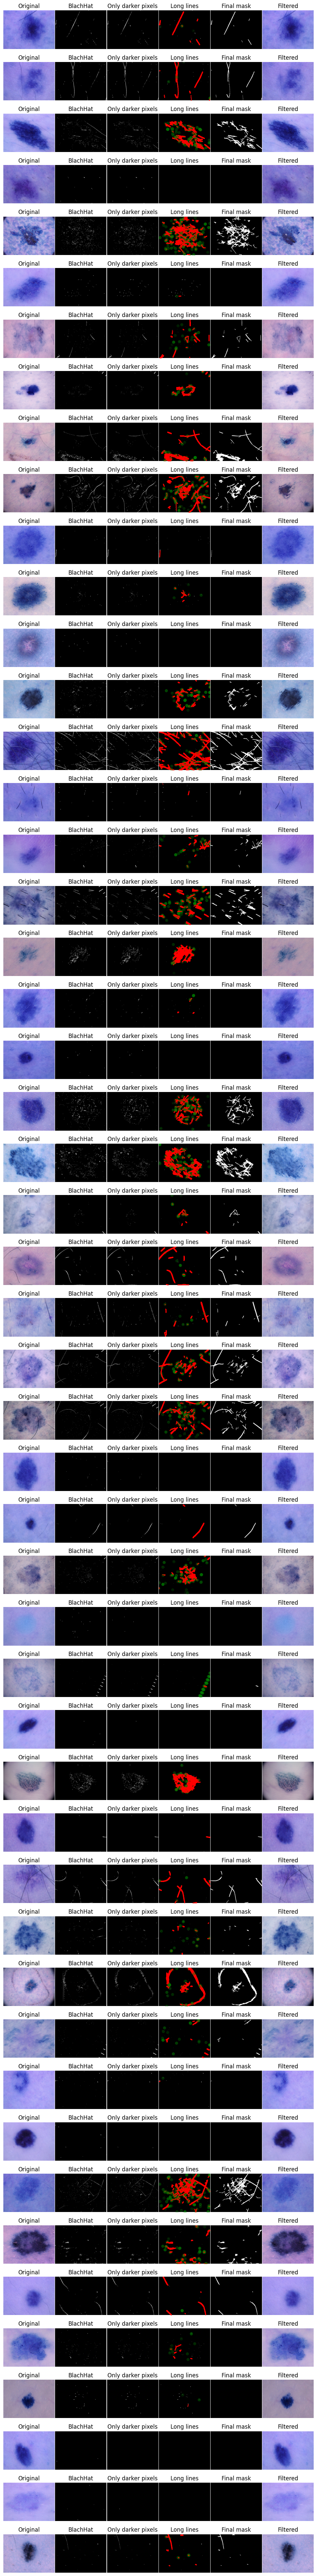

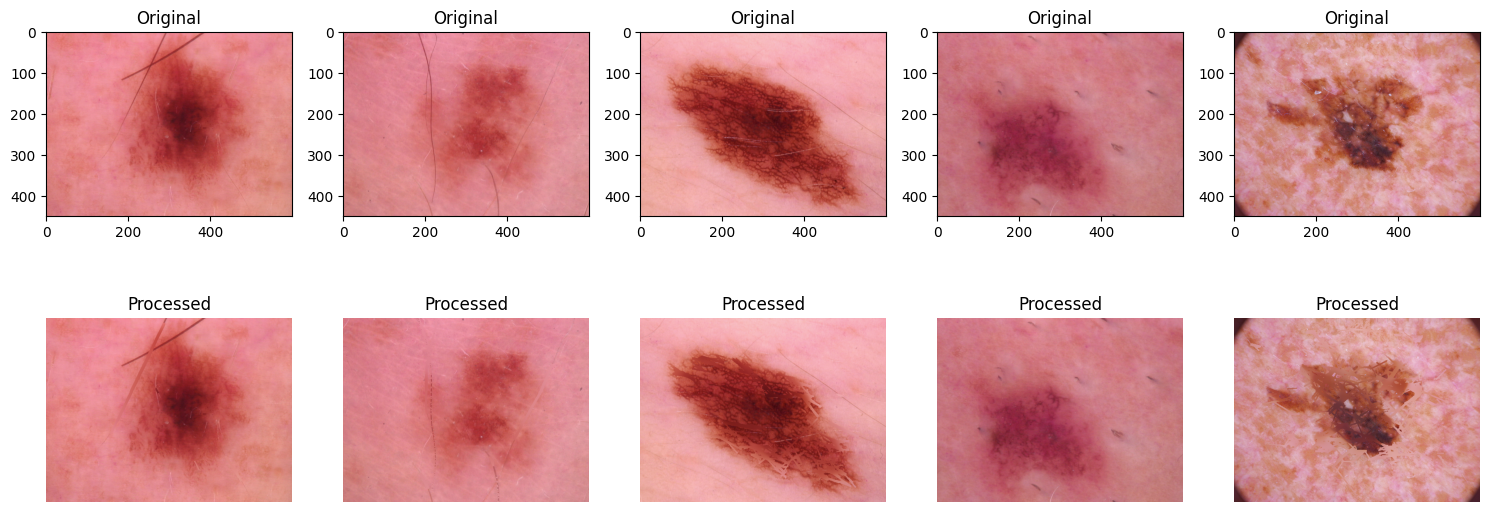

In [14]:


data_path = 'dataset/input_images'
output_path = 'dataset/processed_images'

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)

# Assuming `data_path` is the path to your single directory containing all images
images = []
for file_name in os.listdir(data_path):
    file_path = os.path.join(data_path, file_name)
    img = cv.imread(file_path)
    images.append(img)

# Remove hair from images
images_no_hair = remove_hair(images)

# Save processed images
for idx, img in enumerate(images_no_hair):
    output_file_path = os.path.join(output_path, f"processed_{idx}.png")
    cv.imwrite(output_file_path, img)




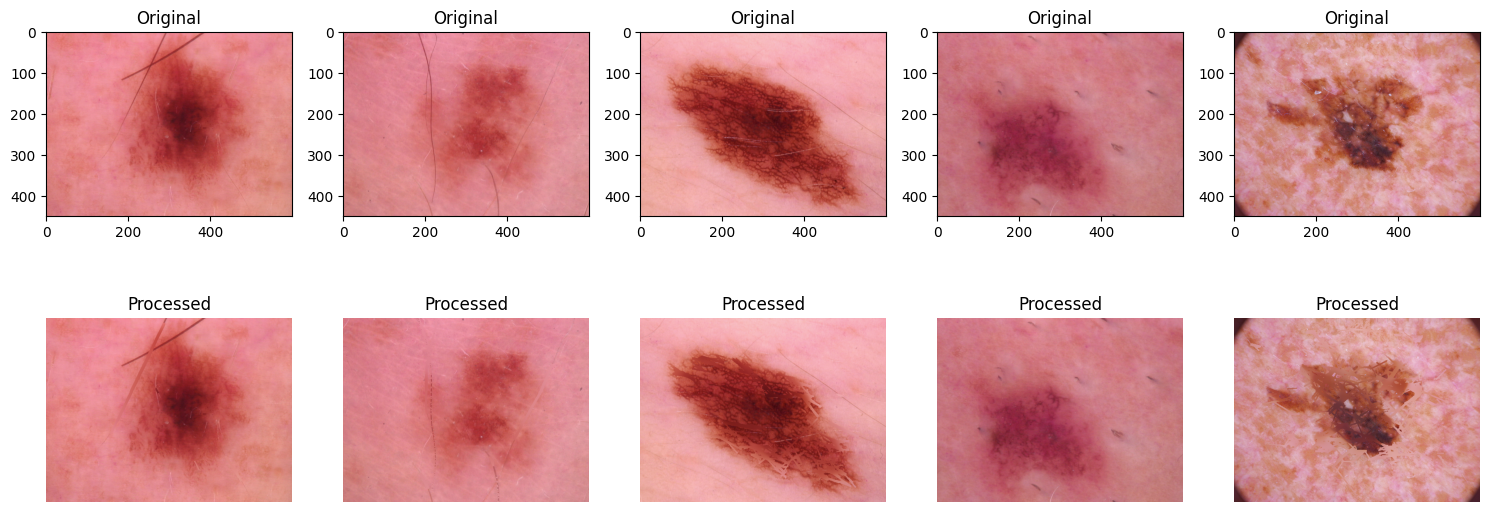

In [15]:
# Display some processed images
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
    plt.axis('on')
    plt.title('Original')
    plt.subplot(2, 5, i + 6)
    plt.imshow(cv.cvtColor(images_no_hair[i], cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Processed')
plt.tight_layout()
plt.show()